In [1]:
import numpy as np
import pandas as pd
from PIL import Image 

from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io

import numpy as np
#import argparse
import random
import os

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")

In [3]:
import tensorflow as tf
import tensorflow.keras as TK
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense
from tensorflow.keras.layers import BatchNormalization,Flatten,Dropout
from tensorflow.keras.layers import Activation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [5]:
class Traffic:
    @staticmethod
    def build(width,height,depth,classes) :
        
        model = Sequential() # model is developed in sequential way
        chanDim = -1
        inputShape = (height, width, depth)
        
        #conv=>Relu=>BN=>Pool
        model.add(Conv2D(8,(5,5),padding='same',input_shape=inputShape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        model.add(Conv2D(16,(3,3),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        
        model.add(Conv2D(16,(3,3),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        model.add(Conv2D(32,(3,3),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32,(3,3),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2))) 
        
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5)) #regularization use to  penalize overfitting
        
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5)) 
        #Since numer of class is greater than 2 we are using softmax activation function
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [6]:
def load_split(basePath,csvPath):
    data=[]
    labels = []
    rows = open(csvPath).read().strip().split("\n")[1:]
    random.shuffle(rows)
    for (i, row) in enumerate(rows):
        # check to see if we should show a status update
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {} total images".format(i))
        # split the row into components and then grab the class ID
     # and image path
        (label, imagePath) = row.strip().split(",")[-2:]
    # derive the full path to the image file and load it
        imagePath = os.path.sep.join([basePath, imagePath])
        image = io.imread(imagePath)

        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)
        # update the list of data and labels, respectively
        data.append(image)
        labels.append(int(label))
    # convert the data and labels to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)
    print("You are using {} images".format(len(labels)))
    # return a tuple of the data and labels
    return (data, labels)

Make sure Dataset is Downloaded 

In [7]:
# Get the current directory's absolute path
basePath = os.path.abspath(os.getcwd())

# Concatenate with the 'Data' folder
basePath = os.path.join(basePath, 'Data')

print(basePath)

trainPath = os.path.sep.join([basePath, "Train.csv"])
testPath = os.path.sep.join([basePath, "Test.csv"])

c:\Users\NewtonMallick\Code\TrafficSignalNet\TrafficSignal\Data


In [8]:
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64
# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]
print(labelNames)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


In [9]:

# load the training and testing data
print("[INFO] loading training data...")
(train_x, train_y) = load_split(basePath, trainPath)
print("\n[INFO] loading testing data...")
(test_x, test_y) = load_split(basePath, testPath)
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0



[INFO] loading training data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total images
[INFO

In [18]:
print('Unique Values')
print(np.unique(train_y))

'''
# calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = trainY.sum(axis=0)
classWeight = dict()
print(classTotals)
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]
'''
from sklearn.utils import class_weight
c_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_y),
                                                 y=train_y)
print(c_weights)

Unique Values
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[4.34208195 0.41073748 0.40526098 0.64669306 0.46052384 0.49023506
 2.17104097 0.63322028 0.64669306 0.62029742 0.45365035 0.69078576
 0.43420819 0.42214686 1.16902206 1.44736065 2.17104097 0.82147496
 0.75986434 4.34208195 2.53288114 2.76314306 2.33804413 1.7879161
 3.37717485 0.60789147 1.51972868 3.79932171 1.68858742 3.37717485
 2.02630491 1.16902206 3.79932171 1.3234212  2.17104097 0.75986434
 2.33804413 4.34208195 0.44050107 3.03945736 2.53288114 3.79932171
 3.79932171]


In [11]:
c_weights = {i:w for i,w in enumerate(c_weights)}
c_weights

{0: 4.342081949058693,
 1: 0.41073748166771423,
 2: 0.4052609819121447,
 3: 0.6466930562427841,
 4: 0.46052384308198263,
 5: 0.49023505876469115,
 6: 2.1710409745293466,
 7: 0.6332202842377261,
 8: 0.6466930562427841,
 9: 0.620297421294099,
 10: 0.45365035288672917,
 11: 0.6907857646229739,
 12: 0.4342081949058693,
 13: 0.4221468561584841,
 14: 1.1690220632081096,
 15: 1.447360649686231,
 16: 2.1710409745293466,
 17: 0.8214749633354285,
 18: 0.7598643410852713,
 19: 4.342081949058693,
 20: 2.5328811369509046,
 21: 2.7631430584918957,
 22: 2.3380441264162193,
 23: 1.7879160966712266,
 24: 3.3771748492678726,
 25: 0.6078914728682171,
 26: 1.5197286821705427,
 27: 3.7993217054263564,
 28: 1.6885874246339363,
 29: 3.3771748492678726,
 30: 2.0263049095607237,
 31: 1.1690220632081096,
 32: 3.7993217054263564,
 33: 1.3234212036318223,
 34: 2.1710409745293466,
 35: 0.7598643410852713,
 36: 2.3380441264162193,
 37: 4.342081949058693,
 38: 0.44050106729580946,
 39: 3.0394573643410854,
 40: 2.532

In [12]:
# one-hot encode the training and testing labels
numLabels = len(np.unique(train_y))
trainY = to_categorical(train_y, numLabels)
testY = to_categorical(test_y, numLabels)

In [ ]:
print("Shape",train_x.shape)
print(trainY[0])
print(train_x[0])


(39209, 32, 32, 3)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[[0.00021634 0.00022499 0.00026144]
  [0.00081388 0.00084264 0.00104575]
  [0.00178265 0.00189156 0.00235294]
  ...
  [0.00130719 0.00109523 0.0011518 ]
  [0.00077165 0.00071545 0.00078431]
  [0.00161142 0.00157959 0.00183007]]

 [[0.00043702 0.00043696 0.00052288]
  [0.00154202 0.00147648 0.00183007]
  [0.00211647 0.00211847 0.00261438]
  ...
  [0.00183007 0.00147302 0.00154613]
  [0.00049834 0.00047517 0.00052288]
  [0.00187013 0.00207778 0.00235294]]

 [[0.00067999 0.00066573 0.00078431]
  [0.00156344 0.00165892 0.0020915 ]
  [0.00233254 0.00254631 0.00313725]
  ...
  [0.00235294 0.00192807 0.00204217]
  [0.00052288 0.00044652 0.00047929]
  [0.0024385  0.00237741 0.00261438]]

 ...

 [[0.00098914 0.00102149 0.00117647]
  [0.00159992 0.00159956 0.00183007]
  [0.00170243 0.0017027  0.00202614]
  ...
  [0.00122635 0.00122649 0.00129085]

In [14]:
%time
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = Traffic.build(width=32, height=32, depth=3,classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the network
print("[INFO] training network...")
H = model.fit(
	aug.flow(train_x, trainY, batch_size=BS),
	validation_data=(test_x, testY),
	steps_per_epoch=train_x.shape[0] // BS,
	epochs=NUM_EPOCHS,
	class_weight=c_weights,
	verbose=1)

CPU times: total: 0 ns
Wall time: 0 ns
[INFO] compiling model...
[INFO] training network...
Epoch 1/30
612/612 [==============================] - 54s 85ms/step - loss: 3.1406 - accuracy: 0.1717 - val_loss: 3.1281 - val_accuracy: 0.1487
Epoch 2/30
612/612 [==============================] - 51s 83ms/step - loss: 1.7172 - accuracy: 0.4286 - val_loss: 1.1251 - val_accuracy: 0.6173
Epoch 3/30
612/612 [==============================] - 56s 92ms/step - loss: 1.1940 - accuracy: 0.5720 - val_loss: 0.7815 - val_accuracy: 0.7360
Epoch 4/30
612/612 [==============================] - 53s 86ms/step - loss: 0.8798 - accuracy: 0.6639 - val_loss: 1.8877 - val_accuracy: 0.4726
Epoch 5/30
612/612 [==============================] - 51s 83ms/step - loss: 0.6957 - accuracy: 0.7311 - val_loss: 0.5266 - val_accuracy: 0.8280
Epoch 6/30
612/612 [==============================] - 52s 86ms/step - loss: 0.5776 - accuracy: 0.7742 - val_loss: 0.5085 - val_accuracy: 0.8323
Epoch 7/30
612/612 [========================

In [15]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))
# save the network to disk
print("[INFO] serializing network to '{}'...".format("Model"))
model.save("Model")

[INFO] evaluating network...
198/198 [==============================] - 2s 8ms/step
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.38      0.80      0.51        60
                              Speed limit (30km/h)       0.58      0.63      0.60       720
                              Speed limit (50km/h)       0.33      0.79      0.46       750
                              Speed limit (60km/h)       0.77      0.28      0.41       450
                              Speed limit (70km/h)       0.97      0.13      0.23       660
                              Speed limit (80km/h)       1.00      0.00      0.01       630
                       End of speed limit (80km/h)       1.00      0.01      0.03       150
                             Speed limit (100km/h)       1.00      0.02      0.05       450
                             Speed limit (120km/h)       0.89      0.31      0.46      

INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


In [16]:
# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Result.png")

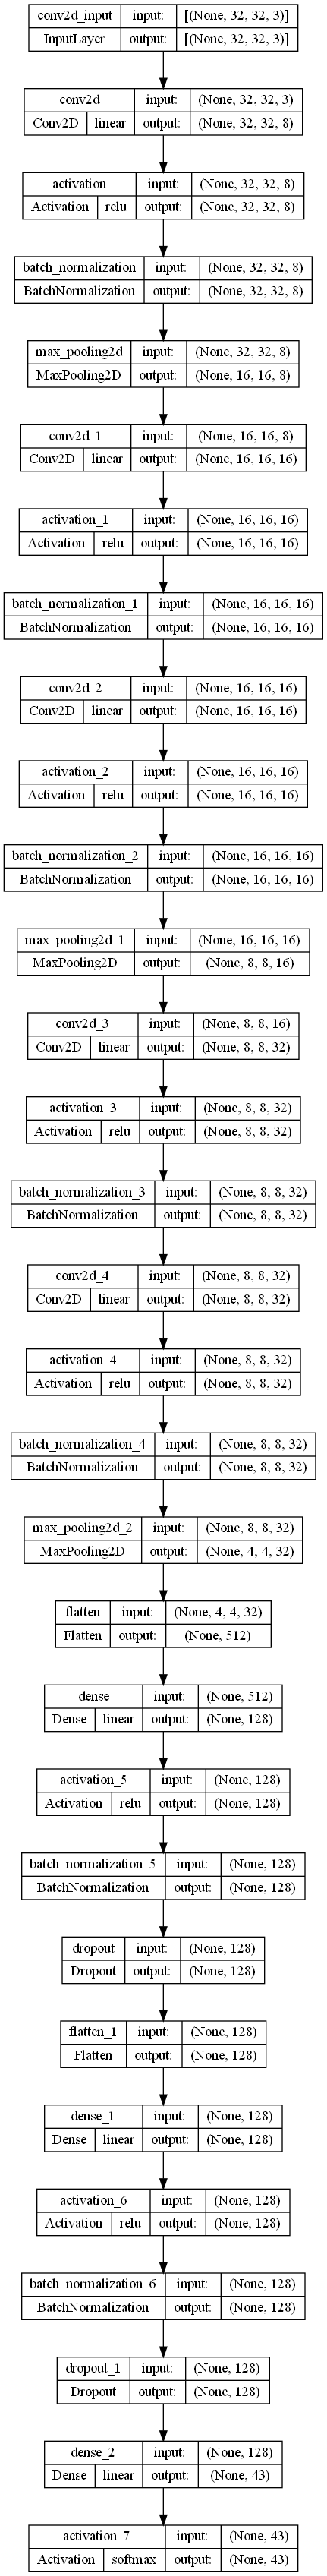

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model,"model.png",show_shapes=True,show_layer_names=True,show_layer_activations=True)